In [1]:
%matplotlib widget

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
from pathlib import Path

In [6]:
from typing import List

In [7]:
from typing import Tuple

In [8]:
from copy import deepcopy

In [9]:
name : str = "stairwellVsTunnel3"

In [10]:
data = pd.read_csv(Path(name) / (name + ".csv"))

In [13]:
name : str = "stairwellVsTunnel3"

In [14]:
spaceStep = data[name + "0::SpaceStep"][0]

In [15]:
timeStep = data[name + "0::TimeStep"][0]

In [16]:
tolerence = spaceStep ** 2

In [17]:
frameCount = len(data[name + "0::SpaceStep"])

In [41]:
count = 6

In [42]:
regionProbabilities : List[List[np.array]] = []
regionNames : List[str] = ["Post", "3rdStair", "2ndStair", "1stStair", "Pre"]
regionIndex : int = 0
for regionName in regionNames: 
    regionProbabilities.append([])
    for ii in range(count): 
         regionProbabilities[regionIndex].append(data[name + str(ii) + "::Probabilities::" + regionName])
    regionIndex += 1

In [43]:
def makeColors(colorCount : int) -> List[Tuple[float, float, float, float]]:
    colors : List[Tuple[int, int, int, int]] = []
    chunkPerComponent : int = round(colorCount / 3) + 1
    currentColor : List[int, int, int, int] = [0.0, 0.0, 0.0, 255]
    colorStep : int = round(255 / (chunkPerComponent + 1))
    for ii in range(chunkPerComponent): 
        for jj in range(3): 
            currentColor[jj] += colorStep
            a = currentColor[(jj + 1) % 3]
            currentColor[(jj + 2) % 3] = np.sqrt(np.abs((currentColor[jj] ** 2) - a ** 2))
            colors.append(np.array(currentColor) / 255)
    return colors

In [44]:
def displayRegion(probabilities : List[np.array], regionName : str, excludeList : List[int] = [], customColors = False): 
    plt.figure()
    legendLabels = []
    ii = 0
    colors : List[Tuple[float, float, float, float]] = makeColors(len(probabilities))
    #colors = np.arange(len(probabilities)) / len(probabilities)
    for probabilitySet in probabilities: 
        if ii in excludeList: 
            ii += 1
            continue
        if customColors == True: 
            plt.plot(np.arange(len(probabilitySet)), probabilitySet, color = colors[ii])
        else: 
            plt.plot(np.arange(len(probabilitySet)), probabilitySet)
        legendLabels.append(regionName + str(ii))
        ii += 1
    plt.title(name)
    plt.legend(legendLabels)

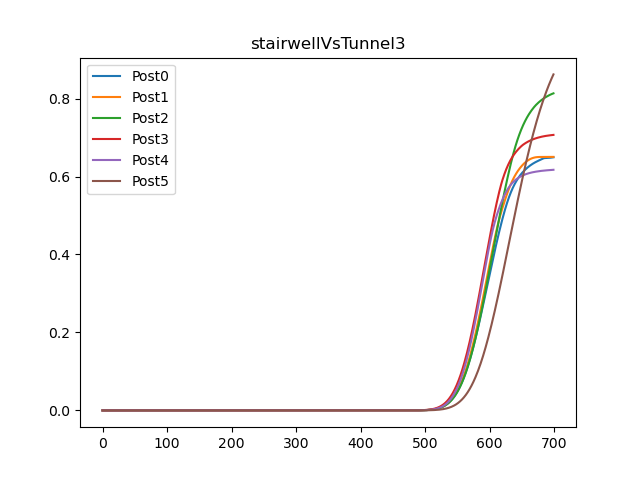

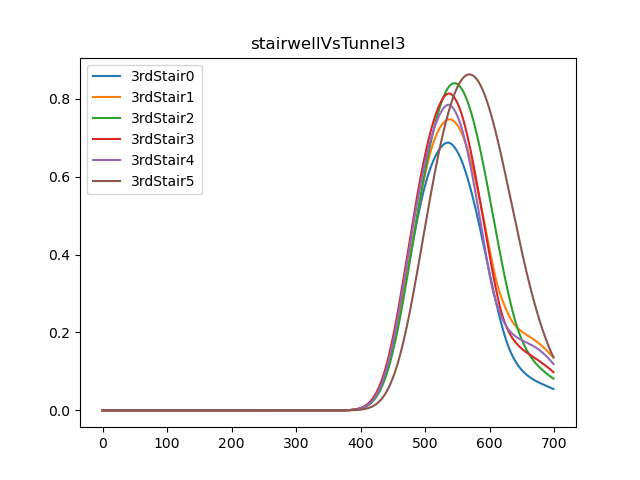

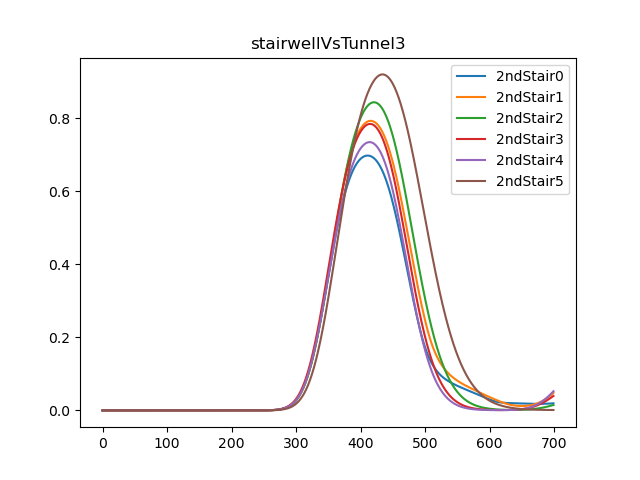

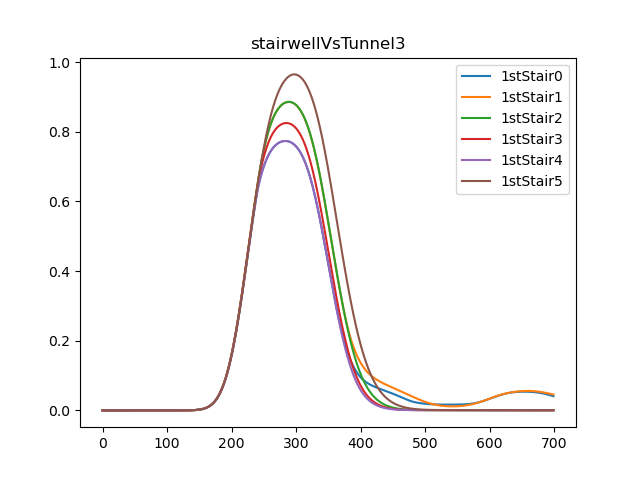

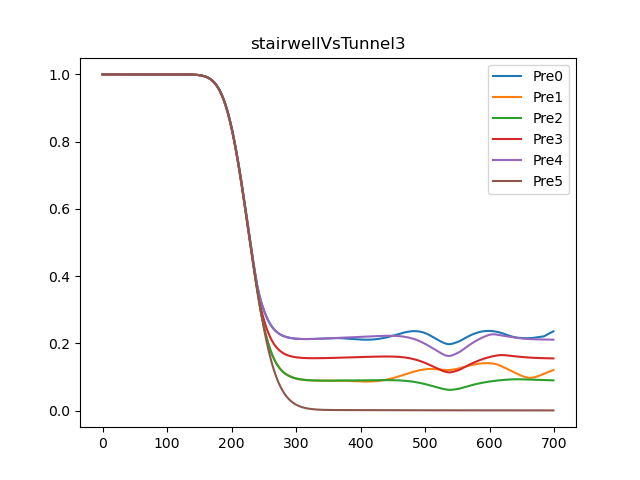

In [45]:
for ii in range(len(regionProbabilities)): 
    displayRegion(regionProbabilities[ii], regionNames[ii])#, [1, 2, 4, 15, 13, 8, 9])

In [54]:
controlCaseIndex = 4
variableCaseIndicies = [0, 1, 2, 3]
regionIndicies = [0, 1, 2, 3]

In [55]:
def computeControlVariableDifferences(
            controlCaseIndex, 
            variableCaseIndicies, 
            regionIndicies
        ): 
    variableFaster = []
    differences = []
    for regionIndex in regionIndicies: 
        differences.append([])
        for variableIndex in variableCaseIndicies: 
            differences[-1].append(regionProbabilities[regionIndex][variableIndex] - regionProbabilities[regionIndex][controlCaseIndex])
            variableFaster.append(np.where((differences[-1][-1] > 0) & (differences[-1][-1] > tolerence)))
    return differences, variableFaster

In [56]:
differences, variableFaster = computeControlVariableDifferences(controlCaseIndex, variableCaseIndicies, regionIndicies)

In [57]:
def plotControlVsVariable(variableIndex, regionIndicies, variableCaseIndicies, differences):
    plt.figure()
    legend = []
    legendTitle = lambda variableIndex, regionIndex : \
            "Variable" + str(variableCaseIndicies[variableIndex]) \
            + ":" + regionNames[regionIndicies[regionIndex]]
    for regionIndex in regionIndicies: 
        plt.plot(np.arange(0, frameCount), differences[regionIndex][variableIndex])
        legend.append(legendTitle(variableIndex, regionIndex))
    errorDigits = np.round(np.abs(np.log10(tolerence))) + 1
    propigatedError = np.sqrt(2 * tolerence ** 2)
    errorString = ("%." + str(int(errorDigits)) + "f") % propigatedError
    plt.ylabel("Difference in Probability +/-" + errorString)
    plt.xlabel("Time Index")
    plt.hlines([propigatedError, -propigatedError], 0, frameCount)
    plt.legend(legend)

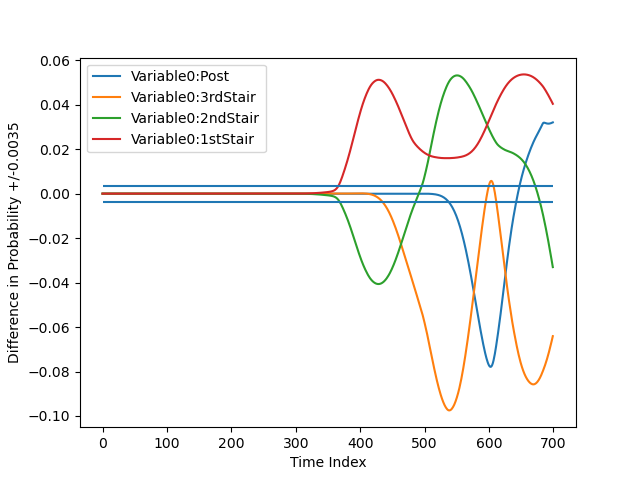

In [58]:
plotControlVsVariable(0, regionIndicies, variableCaseIndicies, differences)

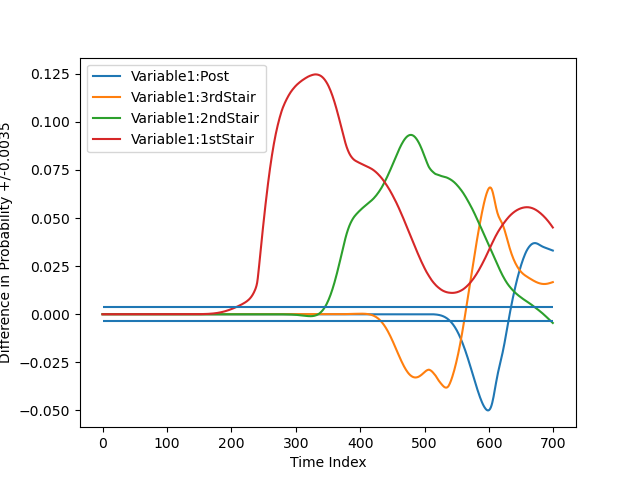

In [59]:
plotControlVsVariable(1, regionIndicies, variableCaseIndicies, differences)

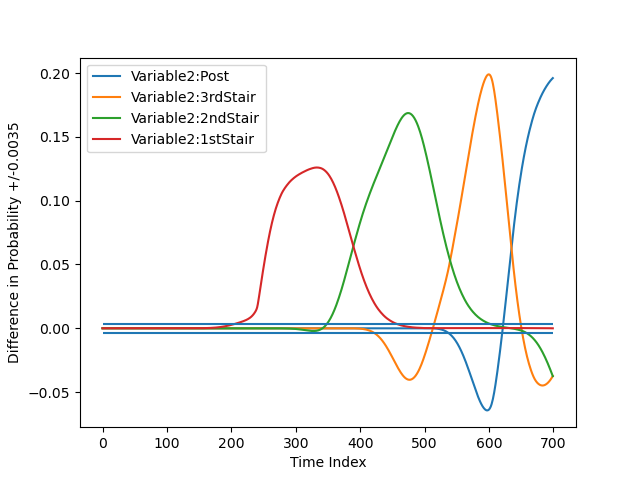

In [60]:
plotControlVsVariable(2, regionIndicies, variableCaseIndicies, differences)

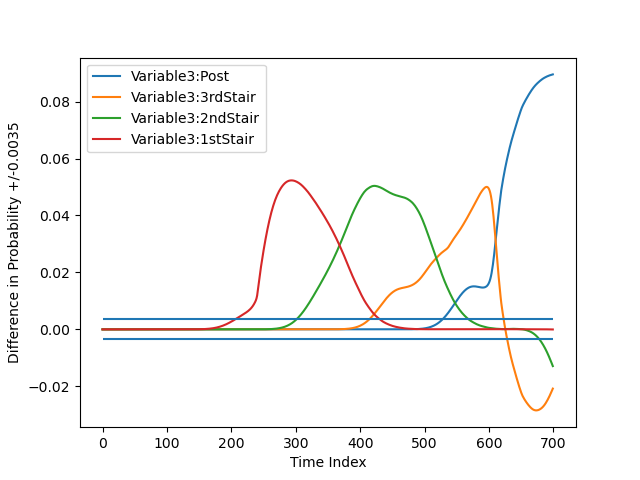

In [66]:
plotControlVsVariable(3, regionIndicies, variableCaseIndicies, differences)

In [61]:
nonFreeParticleIndicies = variableCaseIndicies + [controlCaseIndex]
freeParticleIndex = 13
freeParticleDifferences, variableFaster = computeControlVariableDifferences(freeParticleIndex, nonFreeParticleIndicies, regionIndicies)

IndexError: list index out of range

In [62]:
superluminalLimit = np.where(regionProbabilities[0][13] > 1e-16)[0][0]

IndexError: list index out of range

In [63]:
superluminalLimit 

NameError: name 'superluminalLimit' is not defined

In [64]:
def limitLines(tolerence, waveIndex): 
    tolerenceSuperluminalLimits = []
    for regionIndex in regionIndicies:
        w = np.where(regionProbabilities[regionIndex][waveIndex] >= tolerence)
        tolerenceSuperluminalLimits.append(w[0][0])
    return tolerenceSuperluminalLimits 

In [65]:
def drawLimitLines(index, variableIndicies, tolerence, tolerenceLines): 
    waveIndex = variableIndicies[index]
    tolerenceIntersection = limitLines(tolerence, waveIndex)
    for ii in range(len(tolerenceIntersection)): 
        plt.axvline(tolerenceLines[ii], color = "C0")
        print(tolerenceIntersection[ii])
        plt.axvline(tolerenceIntersection[ii], color = "C1")
        print(tolerenceLines[ii] - tolerenceIntersection[ii])
        regionIndex = regionIndicies[ii]
        probabilities = regionProbabilities[regionIndicies[ii]][waveIndex]
        print("Superluminal Probability Region " + str(regionIndex) \
              + str(np.sum(probabilities[tolerenceIntersection[ii]:tolerenceLines[ii]] * timeStep)))

In [34]:
tolerenceSuperluminalLimits = limitLines(tolerence, 13)

IndexError: list index out of range

In [35]:
plotControlVsVariable(0, regionIndicies, nonFreeParticleIndicies, freeParticleDifferences)
drawLimitLines(0, nonFreeParticleIndicies, tolerence, tolerenceSuperluminalLimits)

NameError: name 'freeParticleDifferences' is not defined

In [36]:
plotControlVsVariable(1, regionIndicies, nonFreeParticleIndicies, freeParticleDifferences)
drawLimitLines(1, nonFreeParticleIndicies, tolerence, tolerenceSuperluminalLimits)

NameError: name 'freeParticleDifferences' is not defined

In [37]:
plotControlVsVariable(2, regionIndicies, nonFreeParticleIndicies, freeParticleDifferences)
drawLimitLines(2, nonFreeParticleIndicies, tolerence, tolerenceSuperluminalLimits)

NameError: name 'freeParticleDifferences' is not defined

In [38]:
plotControlVsVariable(3, regionIndicies, nonFreeParticleIndicies, freeParticleDifferences)
drawLimitLines(3, nonFreeParticleIndicies, tolerence, tolerenceSuperluminalLimits)

NameError: name 'freeParticleDifferences' is not defined

In [39]:
plotControlVsVariable(4, regionIndicies, nonFreeParticleIndicies, freeParticleDifferences)
drawLimitLines(4, nonFreeParticleIndicies, tolerence, tolerenceSuperluminalLimits)

NameError: name 'freeParticleDifferences' is not defined

In [40]:
plotControlVsVariable(5, regionIndicies, nonFreeParticleIndicies, freeParticleDifferences)
drawLimitLines(5, nonFreeParticleIndicies, tolerence, tolerenceSuperluminalLimits)

NameError: name 'freeParticleDifferences' is not defined